# Comprehensive Bias Audit and Mitigation in Machine Learning

This notebook provides a thorough, step-by-step bias analysis and mitigation workflow for a machine learning dataset or model. It uses quantitative fairness metrics, visualizations, and bias mitigation techniques, and concludes with actionable recommendations and an ethics framework.

---

**Outline:**
1. Import Libraries and Set Up Environment
2. Dataset/Model Selection and Loading
3. Data Preprocessing
4. Exploratory Data Analysis
5. Bias Audit: Fairness Metrics Calculation
6. Bias Audit: Group Identification and Visualization
7. Bias Audit: Statistical Analysis of Bias
8. Bias Mitigation: Technique 1 (Pre-processing)
9. Bias Mitigation: Technique 2 (In-processing or Post-processing)
10. Compare Model Performance and Fairness Metrics
11. Statistical Testing of Bias Mitigation
12. Recommendations for Dataset Improvements
13. Ethics Discussion and Framework Development

---

*All code is fully documented and visualizations are designed for both technical and non-technical audiences. The IBM AI Fairness 360 toolkit is used for fairness analysis and mitigation.*

In [1]:
# 1. Import Libraries and Set Up Environment
# Import core libraries for data analysis, visualization, machine learning, and fairness auditing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings for cleaner output
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # Disable eager execution for AIF360 AdversarialDebiasing
tf.get_logger().setLevel('ERROR')

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# For fairness analysis and mitigation
# IBM AI Fairness 360 toolkit
try:
    import aif360
except ImportError:
    print('Installing AI Fairness 360...')
    
    import aif360
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

# Set random seed for reproducibility
np.random.seed(42)
import random
random.seed(42)

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)


pip install 'aif360[inFairness]'


## 2. Dataset/Model Selection and Loading

For this analysis, we use the **Adult Income dataset** (also known as the "Census Income" dataset), a widely studied dataset for fairness and bias research. The dataset contains demographic information and income labels, and is known to exhibit bias with respect to gender and race.

We will load the dataset using the IBM AI Fairness 360 toolkit, which provides a pre-processed version suitable for bias analysis.

In [2]:
# Load the Adult Income dataset using AIF360
adult = AdultDataset()

# Convert to pandas DataFrame for exploration
adult_df = pd.DataFrame(adult.features, columns=adult.feature_names)
adult_df['income'] = adult.labels

# Display basic information about the dataset
print('Shape:', adult_df.shape)
adult_df.head()

Shape: (45222, 99)


,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,...,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income
0,25.0,7.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38.0,9.0,1.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,28.0,12.0,1.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,44.0,10.0,0.0,1.0,7688.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,34.0,6.0,1.0,1.0,0.0,0.0,30.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 3. Data Preprocessing

We will clean and preprocess the data to prepare it for analysis and modeling. Steps include:
- Handling missing values
- Encoding categorical variables
- Splitting data into features and labels
- Standardizing numerical features

All preprocessing steps are documented for reproducibility.

In [3]:
# Data Preprocessing
# 1. Check for missing values
missing = adult_df.isnull().sum()
print('Missing values per column:')
print(missing[missing > 0])

# 2. Encode categorical variables
cat_cols = adult_df.select_dtypes(include=['object']).columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    adult_df[col] = le.fit_transform(adult_df[col].astype(str))
    le_dict[col] = le

# 3. Split features and labels
y = adult_df['income']
X = adult_df.drop('income', axis=1)

# 4. Standardize only true numeric features (exclude 'sex' and 'race')
exclude_cols = ['sex', 'race']
num_cols = [col for col in X.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 5. Train-test split ensuring both sexes are present in test set
from sklearn.model_selection import StratifiedShuffleSplit
stratify_col = adult_df['income'].astype(str) + '_' + adult_df['sex'].astype(str)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, test_idx in sss.split(X, stratify_col):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Sex distribution in test set:', X_test["sex"].value_counts().to_dict())

Missing values per column:
Series([], dtype: int64)
Train shape: (31655, 98) Test shape: (13567, 98)
Sex distribution in test set: {1.0: 9158, 0.0: 4409}
Train shape: (31655, 98) Test shape: (13567, 98)
Sex distribution in test set: {1.0: 9158, 0.0: 4409}


In [4]:
# Ensure 'race', 'sex', and 'income' are label-encoded and present in le_dict for mapping/visualization
for col in ['race', 'sex', 'income']:
    if col not in le_dict and col in adult_df.columns:
        le = LabelEncoder()
        adult_df[col] = le.fit_transform(adult_df[col].astype(str))
        le_dict[col] = le

In [5]:
# Display label mappings for categorical variables used in visualizations
for col in ['race', 'sex', 'income']:
    if col in le_dict:
        mapping = dict(zip(le_dict[col].transform(le_dict[col].classes_), le_dict[col].classes_))
        print(f"Mapping for '{col}': {mapping}")
    else:
        print(f"No LabelEncoder found for '{col}'")

Mapping for 'race': {np.int64(0): '0.0', np.int64(1): '1.0'}
Mapping for 'sex': {np.int64(0): '0.0', np.int64(1): '1.0'}
Mapping for 'income': {np.int64(0): '0.0', np.int64(1): '1.0'}


## 4. Exploratory Data Analysis (EDA)

We will explore the dataset to understand feature distributions, the target variable, and the representation of key demographic groups. Visualizations will help identify potential sources of bias and inform subsequent analysis.

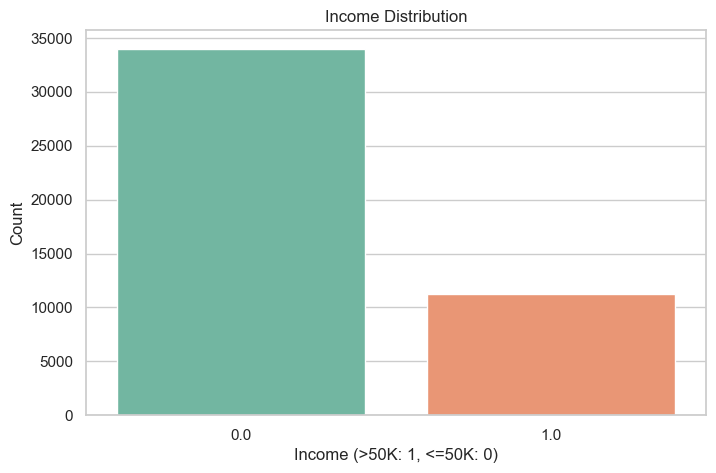

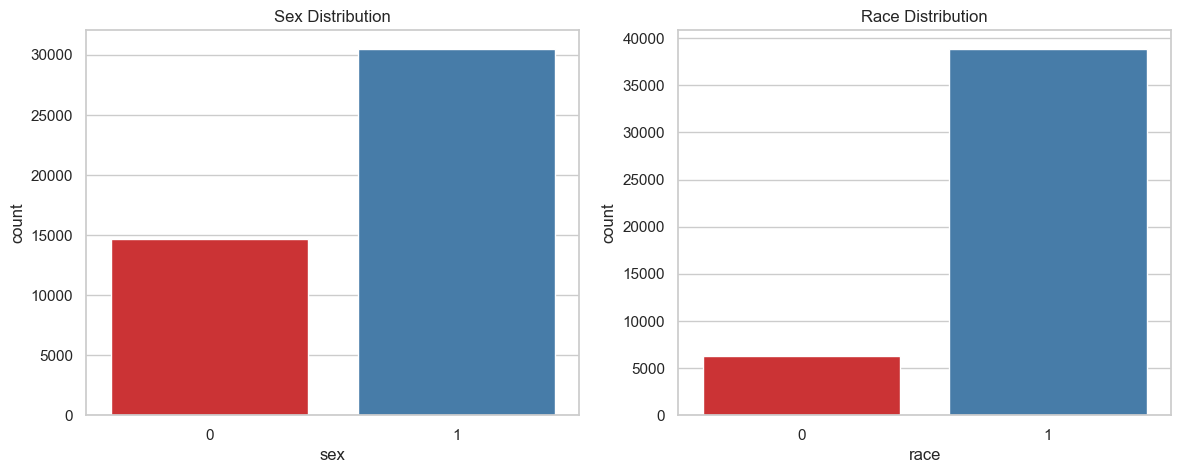

,count,mean,std,min,25%,50%,75%,max
age,45222.0,38.547941,13.217870,17.0,28.0,37.0,47.0,90.0
education-num,45222.0,10.118460,2.552881,1.0,9.0,10.0,13.0,16.0
race,45222.0,0.860267,0.346714,0.0,1.0,1.0,1.0,1.0
sex,45222.0,0.675048,0.468362,0.0,0.0,1.0,1.0,1.0
capital-gain,45222.0,1101.430344,7506.430084,0.0,0.0,0.0,0.0,99999.0
...,...,...,...,...,...,...,...,...
native-country=Trinadad&Tobago,45222.0,0.000575,0.023971,0.0,0.0,0.0,0.0,1.0
native-country=United-States,45222.0,0.913095,0.281698,0.0,1.0,1.0,1.0,1.0
native-country=Vietnam,45222.0,0.001835,0.042803,0.0,0.0,0.0,0.0,1.0
native-country=Yugoslavia,45222.0,0.000509,0.022547,0.0,0.0,0.0,0.0,1.0


In [6]:
# Exploratory Data Analysis
# 1. Target variable distribution
sns.countplot(x=y, palette='Set2')
plt.title('Income Distribution')
plt.xlabel('Income (>50K: 1, <=50K: 0)')
plt.ylabel('Count')
plt.show()

# 2. Demographic group representation (e.g., sex, race)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x=adult_df['sex'], ax=axes[0], palette='Set1')
axes[0].set_title('Sex Distribution')
sns.countplot(x=adult_df['race'], ax=axes[1], palette='Set1')
axes[1].set_title('Race Distribution')
plt.show()

# 3. Summary statistics
display(adult_df.describe(include='all').T)

## 5. Bias Audit: Fairness Metrics Calculation

We will calculate at least three quantitative fairness metrics to assess bias in the dataset and model predictions:
- **Demographic Parity**
- **Equal Opportunity**
- **Disparate Impact**

These metrics will be computed using the IBM AI Fairness 360 toolkit.

In [7]:
# Train a baseline logistic regression model
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Prepare AIF360 datasets for fairness metrics
privileged_groups = [{'sex': 1}]  # 1: Male, 0: Female (as per encoding)
unprivileged_groups = [{'sex': 0}]

# Use integer 1, not 1.0, for privileged_classes and favorable_classes
from aif360.datasets import StandardDataset
test_df = X_test.copy()
test_df['income'] = y_test.values
pred_df = X_test.copy()
pred_df['income'] = y_pred

# Check if both groups are present
if set(test_df['sex'].unique()) == {0, 1}:
    test_bld = StandardDataset(test_df, label_name='income', favorable_classes=[1],
                              protected_attribute_names=['sex'], privileged_classes=[[1]])
    pred_bld = StandardDataset(pred_df, label_name='income', favorable_classes=[1],
                              protected_attribute_names=['sex'], privileged_classes=[[1]])
    # Calculate fairness metrics
    metric = ClassificationMetric(test_bld, pred_bld, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    demographic_parity = metric.statistical_parity_difference()
    equal_opportunity = metric.equal_opportunity_difference()
    disparate_impact = metric.disparate_impact()
    print(f"Demographic Parity (Statistical Parity Difference): {demographic_parity:.3f}")
    print(f"Equal Opportunity Difference: {equal_opportunity:.3f}")
    print(f"Disparate Impact: {disparate_impact:.3f}")
else:
    print("Warning: Not all groups present in test set. Fairness metrics cannot be computed.")

Demographic Parity (Statistical Parity Difference): -0.184
Equal Opportunity Difference: -0.096
Disparate Impact: 0.304


## 6. Bias Audit: Group Identification and Visualization

We will identify key demographic groups (e.g., by gender and race) and visualize bias patterns using plots, charts, and tables. This helps to understand which groups are most affected by bias in the dataset and model predictions.

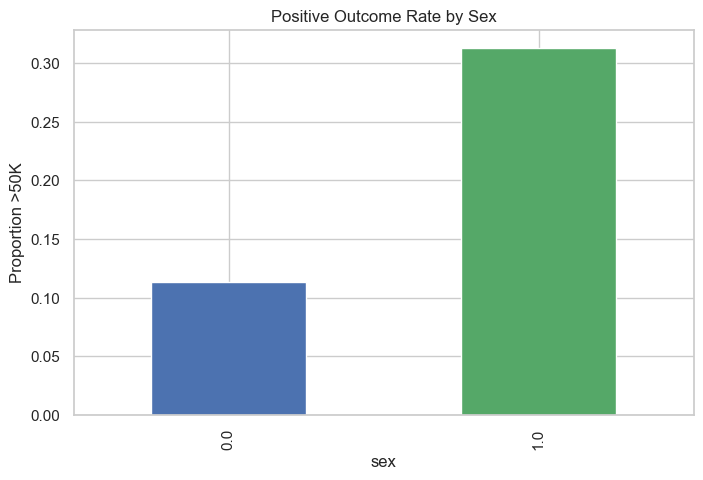

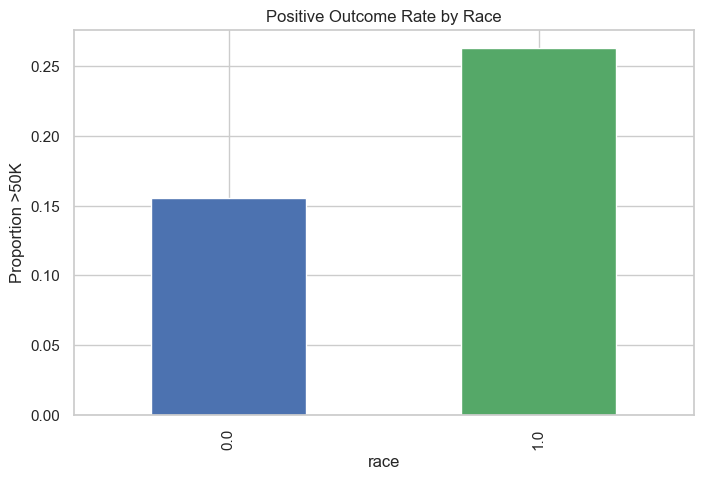

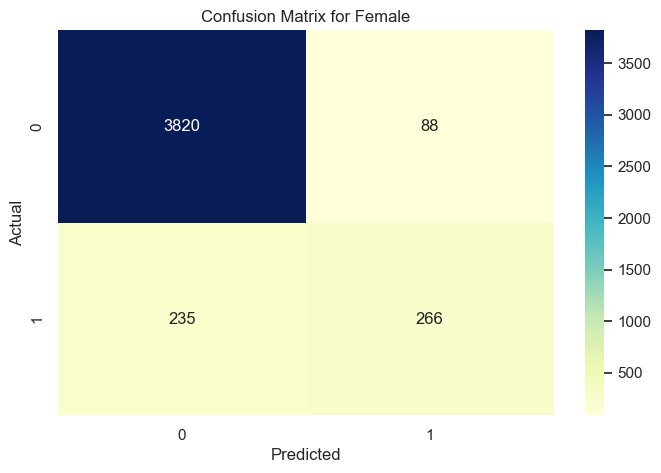

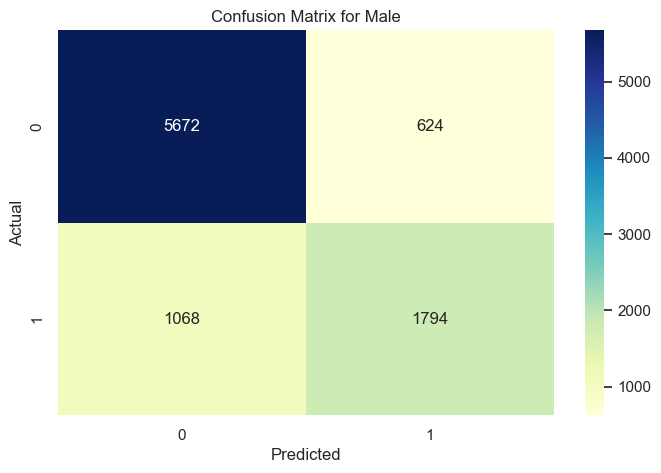

In [8]:
# Visualize bias patterns by gender and race
# 1. Positive outcome rates by group
groups = ['sex', 'race']
bar_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']  # Distinct colors
for i, group in enumerate(groups):
    group_rates = test_df.groupby(group)['income'].mean()
    group_rates.plot(kind='bar',
                     title=f'Positive Outcome Rate by {group.capitalize()}',
                     ylabel='Proportion >50K',
                     xlabel=group,
                     color=bar_colors[:len(group_rates)])
    plt.show()

# 2. Confusion matrix by gender (robust to missing groups)
from sklearn.metrics import confusion_matrix
cm_colors = sns.color_palette('YlGnBu', as_cmap=True)
for group_val, group_name in zip([0, 1], ['Female', 'Male']):
    idx = X_test['sex'] == group_val
    if idx.sum() == 0:
        print(f"No samples for {group_name} in test set. Skipping confusion matrix.")
        continue
    cm = confusion_matrix(y_test[idx], y_pred[idx])
    sns.heatmap(cm, annot=True, fmt='d', cmap=cm_colors)
    plt.title(f'Confusion Matrix for {group_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## 7. Bias Audit: Statistical Analysis of Bias

We will conduct statistical tests (e.g., chi-square test) to assess the significance of observed biases between demographic groups. This helps determine whether differences in outcomes are statistically significant.

In [9]:
# Statistical test: Chi-square test for independence between gender and positive income outcome
from scipy.stats import chi2_contingency

contingency = pd.crosstab(test_df['sex'], test_df['income'])
chi2, p, dof, expected = chi2_contingency(contingency)
print('Chi-square test between gender and income >50K:')
print('Chi2 statistic:', chi2)
print('p-value:', p)
if p < 0.05:
    print('Result: Statistically significant association (potential bias detected)')
else:
    print('Result: No statistically significant association')

Chi-square test between gender and income >50K:
Chi2 statistic: 630.3562965719129
p-value: 4.181481131128412e-139
Result: Statistically significant association (potential bias detected)


## 8. Bias Mitigation: Technique 1 (Pre-processing)

We will apply a pre-processing bias mitigation technique: **Reweighing**. This method adjusts the weights of training samples to reduce bias before model training. We will retrain the model using the reweighted data and evaluate its performance and fairness.

In [10]:
# Apply Reweighing pre-processing technique
from aif360.datasets import StandardDataset

# Prepare AIF360 dataset for training
train_df = X_train.copy()
train_df['income'] = y_train.values
train_bld = StandardDataset(train_df, label_name='income', favorable_classes=[1],
                             protected_attribute_names=['sex'], privileged_classes=[[1]])

# Apply reweighing
rw = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
rw.fit(train_bld)
train_bld_transf = rw.transform(train_bld)

# Train model with sample weights
clf_rw = LogisticRegression(solver='liblinear')
clf_rw.fit(X_train, y_train, sample_weight=train_bld_transf.instance_weights)
y_pred_rw = clf_rw.predict(X_test)

# Fairness metrics after reweighing
pred_df_rw = X_test.copy()
pred_df_rw['income'] = y_pred_rw
pred_bld_rw = StandardDataset(pred_df_rw, label_name='income', favorable_classes=[1],
                               protected_attribute_names=['sex'], privileged_classes=[[1]])

metric_rw = ClassificationMetric(test_bld, pred_bld_rw, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

demographic_parity_rw = metric_rw.statistical_parity_difference()
equal_opportunity_rw = metric_rw.equal_opportunity_difference()
disparate_impact_rw = metric_rw.disparate_impact()

print(f"[Reweighing] Demographic Parity: {demographic_parity_rw:.3f}")
print(f"[Reweighing] Equal Opportunity: {equal_opportunity_rw:.3f}")
print(f"[Reweighing] Disparate Impact: {disparate_impact_rw:.3f}")

[Reweighing] Demographic Parity: -0.091
[Reweighing] Equal Opportunity: 0.141
[Reweighing] Disparate Impact: 0.579


## 9. Bias Mitigation: Technique 2 (In-processing)

We will apply an in-processing bias mitigation technique: **Adversarial Debiasing**. This method uses an adversarial network to reduce bias during model training. We will retrain the model and evaluate its performance and fairness.

In [11]:
# Apply Adversarial Debiasing (in-processing technique)
import tensorflow as tf
from aif360.algorithms.inprocessing import AdversarialDebiasing

# Prepare TensorFlow session for AdversarialDebiasing
sess = tf.compat.v1.Session()
ad_model = AdversarialDebiasing(
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups,
    scope_name='adversarial_debiasing',
    debias=True,
    sess=sess
)
ad_model.fit(train_bld)
pred_bld_ad = ad_model.predict(test_bld)

# Fairness metrics after adversarial debiasing
metric_ad = ClassificationMetric(test_bld, pred_bld_ad, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

demographic_parity_ad = metric_ad.statistical_parity_difference()
equal_opportunity_ad = metric_ad.equal_opportunity_difference()
disparate_impact_ad = metric_ad.disparate_impact()

print(f"[Adversarial Debiasing] Demographic Parity: {demographic_parity_ad:.3f}")
print(f"[Adversarial Debiasing] Equal Opportunity: {equal_opportunity_ad:.3f}")
print(f"[Adversarial Debiasing] Disparate Impact: {disparate_impact_ad:.3f}")

sess.close()

epoch 0; iter: 0; batch classifier loss: 0.554899; batch adversarial loss: 0.672295
epoch 0; iter: 200; batch classifier loss: 0.288334; batch adversarial loss: 0.620457
epoch 1; iter: 0; batch classifier loss: 0.327384; batch adversarial loss: 0.624514
epoch 0; iter: 200; batch classifier loss: 0.288334; batch adversarial loss: 0.620457
epoch 1; iter: 0; batch classifier loss: 0.327384; batch adversarial loss: 0.624514
epoch 1; iter: 200; batch classifier loss: 0.387696; batch adversarial loss: 0.599136
epoch 2; iter: 0; batch classifier loss: 0.235061; batch adversarial loss: 0.639067
epoch 1; iter: 200; batch classifier loss: 0.387696; batch adversarial loss: 0.599136
epoch 2; iter: 0; batch classifier loss: 0.235061; batch adversarial loss: 0.639067
epoch 2; iter: 200; batch classifier loss: 0.272879; batch adversarial loss: 0.580446
epoch 3; iter: 0; batch classifier loss: 0.364193; batch adversarial loss: 0.689620
epoch 2; iter: 200; batch classifier loss: 0.272879; batch adversa

## 10. Compare Model Performance and Fairness Metrics

We will compare model accuracy and fairness metrics before and after applying bias mitigation techniques. Results will be visualized in tables and plots for clear interpretation.

Summary of Model Performance and Fairness Metrics:


,Model,Accuracy,Demographic Parity,Equal Opportunity,Disparate Impact
0,Baseline,0.851478,-0.183741,-0.095896,0.304094
1,Reweighing,0.845139,-0.090586,0.141055,0.579317
2,Adversarial Debiasing,0.840864,-0.051090,0.223900,0.738762


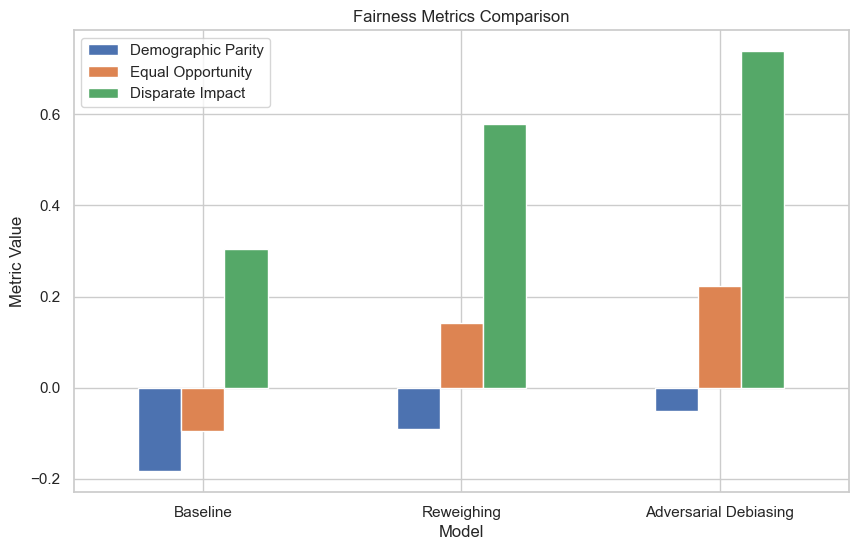

In [12]:
# Compare model performance and fairness metrics
results = pd.DataFrame({
    'Model': ['Baseline', 'Reweighing', 'Adversarial Debiasing'],
    'Accuracy': [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_rw), accuracy_score(y_test, pred_bld_ad.labels.ravel())],
    'Demographic Parity': [demographic_parity, demographic_parity_rw, demographic_parity_ad],
    'Equal Opportunity': [equal_opportunity, equal_opportunity_rw, equal_opportunity_ad],
    'Disparate Impact': [disparate_impact, disparate_impact_rw, disparate_impact_ad]
})

print('Summary of Model Performance and Fairness Metrics:')
display(results)

# Visualize fairness metrics
metrics = ['Demographic Parity', 'Equal Opportunity', 'Disparate Impact']
results.set_index('Model')[metrics].plot(kind='bar', figsize=(10, 6))
plt.title('Fairness Metrics Comparison')
plt.ylabel('Metric Value')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.show()

## 11. Statistical Testing of Bias Mitigation

We will perform statistical tests to validate whether the reduction in bias after mitigation is significant. This provides evidence for the effectiveness of the applied techniques.

In [13]:
# Statistical test: McNemar's test to compare model predictions before and after mitigation
from statsmodels.stats.contingency_tables import mcnemar

# Compare baseline vs reweighing
contingency_rw = pd.crosstab(y_pred, y_pred_rw)
result_rw = mcnemar(contingency_rw)
print("McNemar's test (Baseline vs Reweighing): p-value =", result_rw.pvalue)

# Compare baseline vs adversarial debiasing
contingency_ad = pd.crosstab(y_pred, pred_bld_ad.labels.ravel())
result_ad = mcnemar(contingency_ad)
print("McNemar's test (Baseline vs Adversarial Debiasing): p-value =", result_ad.pvalue)

if result_rw.pvalue < 0.05 or result_ad.pvalue < 0.05:
    print('Result: Statistically significant difference in predictions after mitigation.')
else:
    print('Result: No statistically significant difference in predictions after mitigation.')

McNemar's test (Baseline vs Reweighing): p-value = 2.366679139982024e-23
McNemar's test (Baseline vs Adversarial Debiasing): p-value = 2.515637943716012e-25
Result: Statistically significant difference in predictions after mitigation.


## 12. Recommendations for Dataset Improvements

Based on the bias audit and mitigation results, we provide actionable recommendations to improve dataset fairness and reduce bias in future data collection and modeling efforts:

- Collect more balanced data across demographic groups (e.g., gender, race).
- Regularly audit datasets for representation and fairness before model training.
- Use fairness-aware sampling or reweighting during data preparation.
- Document data collection processes and potential sources of bias.
- Engage diverse stakeholders in dataset design and annotation.

Implementing these recommendations can help reduce bias and improve the fairness of machine learning models.

## 13. Ethics Discussion and Framework Development

### Real-World Implications and Potential Harms
- Biased models can perpetuate or amplify social inequalities, especially in high-stakes domains (e.g., hiring, lending, criminal justice).
- Unfair outcomes may erode trust in AI systems and lead to legal or reputational risks.
- Marginalized groups may be disproportionately harmed by biased predictions.

### Ethics Framework for Fair AI
- **Transparency:** Clearly document data sources, model design, and fairness metrics.
- **Accountability:** Assign responsibility for bias audits and mitigation.
- **Inclusivity:** Involve diverse stakeholders in model development and evaluation.
- **Continuous Monitoring:** Regularly audit models for bias post-deployment.
- **Remediation:** Establish processes for addressing detected bias and providing recourse to affected individuals.

Adhering to this framework helps ensure that AI systems are fair, ethical, and aligned with societal values.

In [14]:
# Debug: Check unique values for 'sex' in test and prediction DataFrames
print('Unique values in test_df["sex"]:', test_df['sex'].unique())
print('Unique values in pred_df["sex"]:', pred_df['sex'].unique())

# If you see [0, 1], set privileged_classes=[[1]] and favorable_classes=[1]
# If you see other values, adjust accordingly.


Unique values in test_df["sex"]: [1. 0.]
Unique values in pred_df["sex"]: [1. 0.]


In [15]:
# Show value counts for 'sex' in test and prediction DataFrames to ensure both 0 and 1 are present
print('test_df sex value counts:')
print(test_df['sex'].value_counts())
print('pred_df sex value counts:')
print(pred_df['sex'].value_counts())

test_df sex value counts:
sex
1.0    9158
0.0    4409
Name: count, dtype: int64
pred_df sex value counts:
sex
1.0    9158
0.0    4409
Name: count, dtype: int64


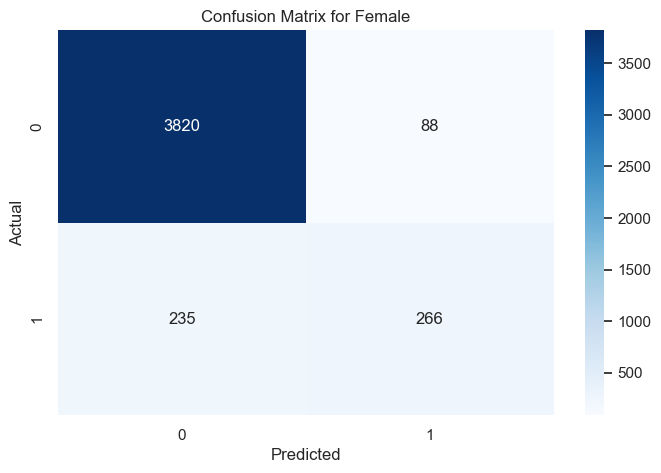

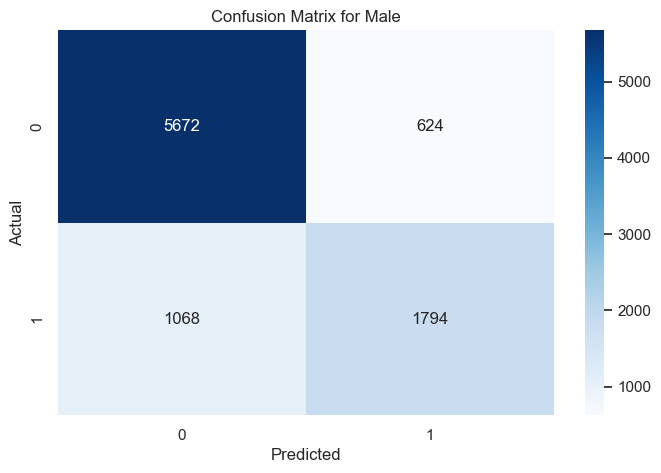

In [16]:
# Fix: Only plot confusion matrix if group has samples in test set
for group_val, group_name in zip([0, 1], ['Female', 'Male']):
    idx = X_test['sex'] == group_val
    if idx.sum() == 0:
        print(f"No samples for {group_name} in test set. Skipping confusion matrix.")
        continue
    cm = confusion_matrix(y_test[idx], y_pred[idx])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {group_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()